In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from zimp.pos.statistics_analyzer import TextLengthAnalyzer
from zimp.pos.countvectorizer_analyzer import SymbolCountVectorizerAnalyzer
from glob import glob

plt.style.use('seaborn-whitegrid')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!


In [2]:
source_dir = '../../zimp_orchestrator/orch/resources'
files = {}
for ds_path in glob(source_dir + '/*'):
    if not os.path.isdir(ds_path):
        continue
    ds_name = os.path.basename(ds_path)
    files[ds_name] = [os.path.join(ds_path, 'train.csv'), os.path.join(ds_path, 'test.csv')]

In [3]:
def get_ds_stats(paths, analyzer_builder, track_name):
    texts = pd.read_csv(paths[0]).text.append(pd.read_csv(paths[1]).text)
    df =  analyzer_builder(texts).extract_dataset_metric().rename(columns={'count': track_name})
    return df

In [4]:
dfs = []
for dataset in files.keys():
    dfs.append(get_ds_stats(files[dataset], lambda texts: TextLengthAnalyzer(texts), dataset))
df = pd.concat(dfs, axis=1)
df_rel = df/df.sum(axis=0)
df_rel

,10K-GNAD,DBP-14,GERMEVAL-2018,GERMEVAL-2020,TREC-6,YELP-5
1,NaN,NaN,NaN,NaN,NaN,0.000023
2,NaN,NaN,NaN,NaN,NaN,0.000030
3,NaN,NaN,NaN,NaN,NaN,0.000043
4,NaN,NaN,NaN,NaN,NaN,0.000047
5,NaN,NaN,NaN,NaN,NaN,0.000064
...,...,...,...,...,...,...
18814,0.000097,NaN,NaN,NaN,NaN,NaN
18847,0.000097,NaN,NaN,NaN,NaN,NaN
19011,0.000097,NaN,NaN,NaN,NaN,NaN
22120,0.000097,NaN,NaN,NaN,NaN,NaN


In [5]:
def cropped_line_plot(df, allow_crop=True):
    
    if allow_crop and len(df.index) > 250:
        # remove all values above 95-percentile
        cs = df.sum(axis=1).cumsum()
        max_idx = min(max(cs[cs< cs.iloc[-1]*.95].idxmax(),200), df.index.max())
        df_plot = df[df.index <= max_idx]
        # resample to 100 equal-size intervals
        df_plot = df_plot.groupby(pd.cut(df_plot.index, 100))\
            .agg(lambda s: s.sum())\
            .rename(lambda idx: max(idx.left, 0))\
            .fillna(0)
    else:
        df_plot = df
    
    df_plot.plot(
        figsize=(10,5),
        color=plt.cm.jet(np.linspace(0, 1, len(df_plot.columns))),
        alpha=.5,
        title=f'Length of observations',
        xlabel='Number of characters',
        ylabel='Ratio'
    )
    
    plt.savefig(f'text_statistics/005_character_count.pdf')
    plt.show()

In [6]:
def violin_plot(df):
    
    df_plot = df
        
    fig, axes = plt.subplots(figsize=(15,5))

    v_parts = axes.violinplot(dataset = [df_plot.index.repeat(df_plot[col].fillna(0)) for col in df_plot.columns], showmedians=True)
    axes.set_ylim((-5,10000))

    colors=plt.cm.jet(np.linspace(0, 1, len(df.columns)))

    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = v_parts[partname]
        vp.set_edgecolor('#000000')
        vp.set_linewidth(.5 if partname == 'cbars' else 1)
        vp.set_alpha(.5 if partname == 'cbars' else 1)

    # Make the violin body blue with a red border:
    for idx, vp in enumerate(v_parts['bodies']):
        vp.set_facecolor(colors[idx])
        vp.set_edgecolor(colors[idx])
        vp.set_linewidth(1)
        vp.set_alpha(0.5)

    axes.set_title(f'Text length for different datasets')
    axes.yaxis.grid(True)
    axes.set_xlabel('Dataset')
    axes.set_ylabel('Count of Characters')
    axes.set_xticks(np.arange(1, len(df_plot.columns) + 1), labels=df_plot.columns, fontsize=8)
    
    plt.savefig(f'text_statistics/005_violinplot_text_length.pdf')
    plt.show()

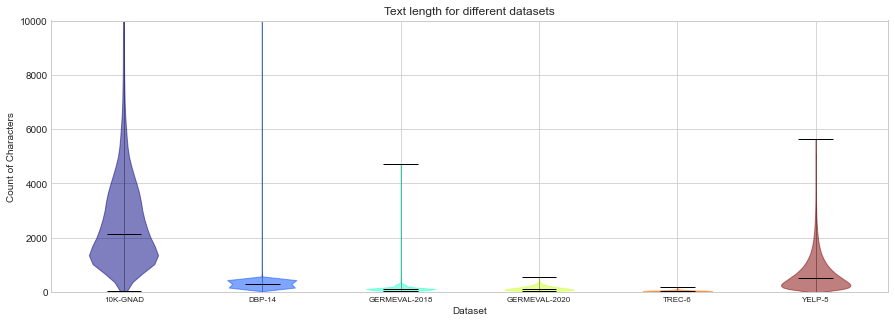

In [7]:
violin_plot(df)

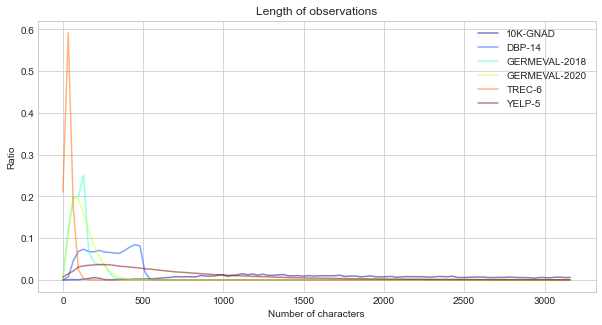

In [8]:
cropped_line_plot(df_rel)

In [9]:
df_len = pd.concat([df.index.repeat(df[col].fillna(0)).to_series().describe() for col in df.columns], axis=1, keys=df.columns)
df_len

,10K-GNAD,DBP-14,GERMEVAL-2018,GERMEVAL-2020,TREC-6,YELP-5
count,10273.000000,630000.000000,8407.000000,188087.000000,5952.000000,700000.000000
mean,2591.636523,303.255019,136.378018,144.271125,49.399362,732.403917
std,1877.818278,138.820387,114.368663,74.672191,20.676899,663.743559
min,25.000000,14.000000,26.000000,29.000000,13.000000,1.000000
25%,1303.000000,186.000000,85.000000,88.000000,35.000000,287.000000
50%,2158.000000,304.000000,125.000000,129.000000,46.000000,539.000000
75%,3419.000000,423.000000,152.000000,185.000000,60.000000,957.000000
max,32600.000000,13576.000000,4700.000000,540.000000,196.000000,5637.000000


### Symbol Analysis

In [10]:
stat_file = 'text_statistics/character_stats.csv'
if os.path.exists(stat_file):
    df = pd.read_csv(stat_file, index_col=0)
else:
    dfs = []
    for dataset in files.keys():
        dfs.append(get_ds_stats(files[dataset], lambda texts: SymbolCountVectorizerAnalyzer(texts, remove_whitespace=False), dataset+'_all'))
        dfs.append(get_ds_stats(files[dataset], lambda texts: SymbolCountVectorizerAnalyzer(texts, lowercase=True, only_alphabetic=True), dataset+'_alpha_lower'))
    df = pd.concat(dfs, axis=1)
    df.to_csv(stat_file)
df

,10K-GNAD_all,10K-GNAD_alpha_lower,DBP-14_all,DBP-14_alpha_lower,GERMEVAL-2018_all,GERMEVAL-2018_alpha_lower,GERMEVAL-2020_all,GERMEVAL-2020_alpha_lower,TREC-6_all,TREC-6_alpha_lower,YELP-5_all,YELP-5_alpha_lower
,3745597.0,NaN,31423560.0,NaN,151442.0,NaN,3672177.0,NaN,53441.0,NaN,95029550.0,NaN
e,3441362.0,3520602.0,15582067.0,15901036.0,132089.0,136477.0,3773512.0,3812730.0,25361.0,25663.0,49382071.0,49839767.0
n,2120796.0,2164365.0,10830869.0,11231510.0,82951.0,85946.0,2099832.0,2113851.0,14114.0,14591.0,26043532.0,26468535.0
i,1719306.0,1766312.0,11817533.0,12444997.0,71401.0,74864.0,1972244.0,1988390.0,15275.0,15882.0,24032627.0,27509786.0
r,1616682.0,1673671.0,9515814.0,10056531.0,62347.0,67368.0,1548583.0,1572661.0,13219.0,13587.0,22434318.0,22746938.0
...,...,...,...,...,...,...,...,...,...,...,...,...
🇫,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
🇯,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
🇲,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
¶,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [11]:
df_all = df.loc[:, [col for col in df.columns if col.endswith('_all')]]
df_all.columns = [col.split('_')[0] for col in df_all.columns]
df_low = df.loc[:, [col for col in df.columns if not col.endswith('_all')]]
df_low.columns = [col.split('_')[0] for col in df_low.columns]

In [12]:
df_all[df_all[key] >= df_all[key].sum()/20]

NameError: name 'key' is not defined

In [ ]:
observation_counts = []
for key in files.keys():
    obs_count = pd.read_csv(files[key][0]).text.size + pd.read_csv(files[key][1]).text.size
    observation_counts.append({
        'dataset': key,
        'observation_count': obs_count,
        'vocab_size_all': df_all[key].count(),
        'vocab_size_all_0001': df_all[df_all[key] >= obs_count/1000][key].count(),
        'vocab_size_all_001': df_all[df_all[key] >= obs_count/100][key].count(),
        'vocab_size_all_01': df_all[df_all[key] >= obs_count/10][key].count(),
        'vocab_size_all_tf_001': df_all[df_all[key] >= df_all[key].sum()/1000][key].count(),
        'vocab_size_all_tf_01': df_all[df_all[key] >= df_all[key].sum()/100][key].count(),
        'vocab_size_all_tf_05': df_all[df_all[key] >= df_all[key].sum()/20][key].count(),
        'vocab_size_low': df_low[key].count(),
        'vocab_size_low_0001': df_low[df_low[key] >= obs_count/1000][key].count(),
        'vocab_size_low_001': df_low[df_low[key] >= obs_count/100][key].count(),
        'vocab_size_low_01': df_low[df_low[key] >= obs_count/10][key].count(),
        'vocab_size_low_tf_001': df_low[df_low[key] >= df_low[key].sum()/1000][key].count(),
        'vocab_size_low_tf_01': df_low[df_low[key] >= df_low[key].sum()/100][key].count(),
        'vocab_size_low_tf_05': df_low[df_low[key] >= df_low[key].sum()/20][key].count(),
    })

In [ ]:
df_symbols = pd.DataFrame(observation_counts).set_index('dataset')
df_symbols

In [ ]:
df_low[['10K-GNAD', 'GERMEVAL-2018', 'GERMEVAL-2020']].sum(axis=1).sort_values(ascending=False).head(n=50)

In [ ]:
df_low[['DBP-14', 'TREC-6', 'YELP-5']].sum(axis=1).sort_values(ascending=False).head(n=50)